In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [2]:
# Packages for analysis
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
# Packages for visuals
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.2)
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
%pdb

Automatic pdb calling has been turned ON


# Worming Our Way Into Machine Learning

### Lan Guo

## NemaMetrix Lunch & Learn

#### 2019-03-27

# What is machine learning?

Wikipedia: **Machine learning** (ML) is the scientific study of algorithms and statistical models

that computer systems use to effectively perform a specific task 

without using explicit instructions, relying on *patterns* and inference instead.

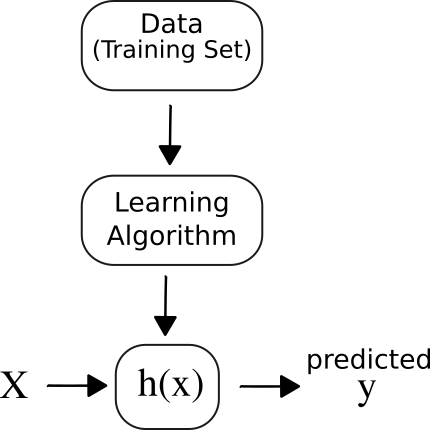

In [3]:
Image(filename='intro.png')

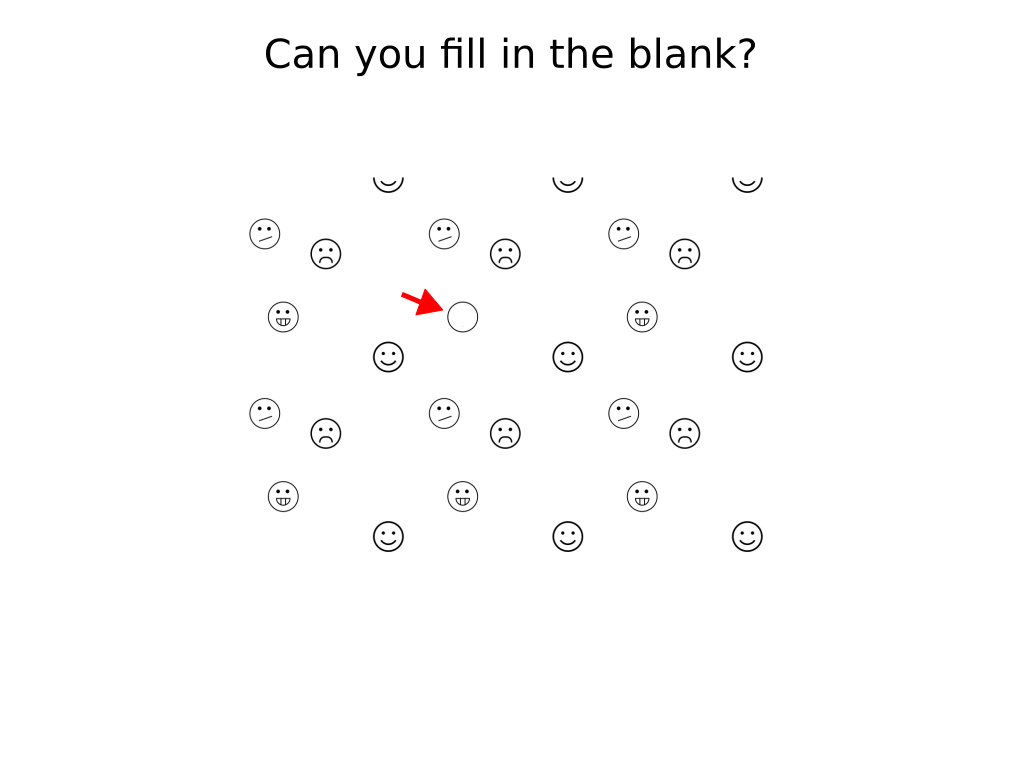

In [4]:
Image(filename='pattern1.png')

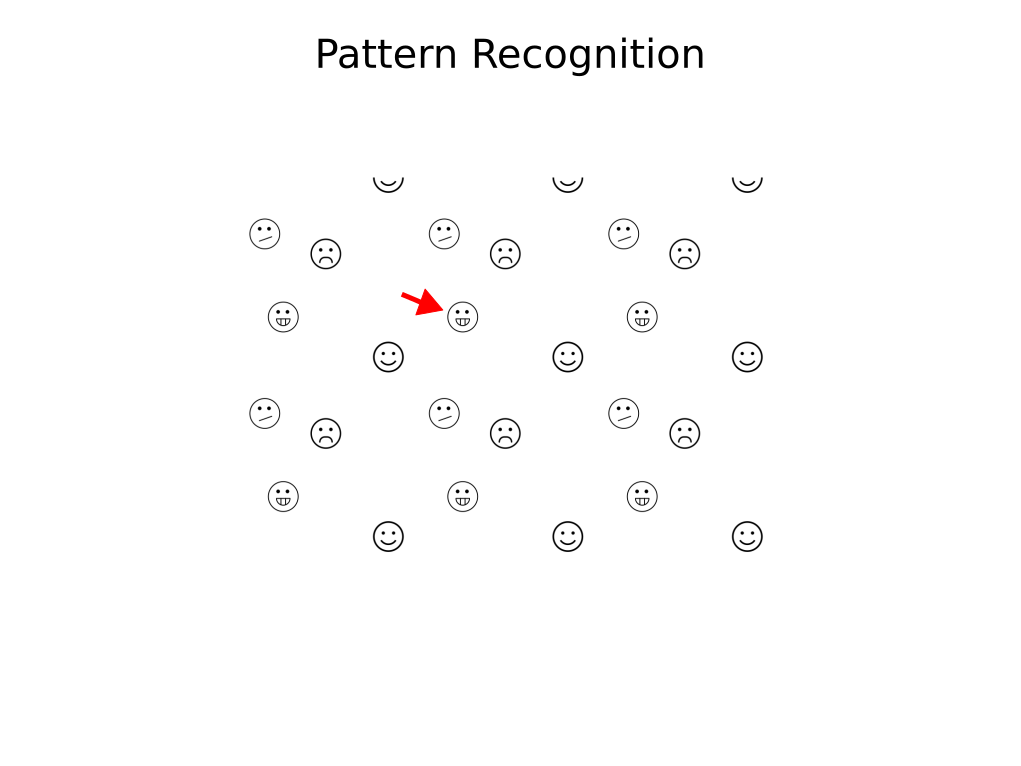

In [5]:
Image(filename='pattern2.png')

# **Are Muffins And Cupcakes The Same Thing**?

## - ML is more useful than you think! 

# How would you tell the difference?

In [6]:
# Read in muffin and cupcake ingredient data
recipes = pd.read_csv('recipes_muffins_cupcakes.csv')

print('Thanks Alice! (https://github.com/adashofdata/muffin-cupcake)')

recipes


Thanks Alice! (https://github.com/adashofdata/muffin-cupcake)


,Type,Flour,Milk,Sugar,Butter,Egg,Baking Powder,Vanilla,Salt
0,Muffin,55,28,3,7,5,2,0,0
1,Muffin,47,24,12,6,9,1,0,0
2,Muffin,47,23,18,6,4,1,0,0
3,Muffin,45,11,17,17,8,1,0,0
4,Muffin,50,25,12,6,5,2,1,0
5,Muffin,55,27,3,7,5,2,1,0
6,Muffin,54,27,7,5,5,2,0,0
7,Muffin,47,26,10,10,4,1,0,0
8,Muffin,50,17,17,8,6,1,0,0
9,Muffin,50,17,17,11,4,1,0,0


So we have a bunch of recipes, we will call them our **data**.

Each data point (recipe) has a bunch of ingredients

In [7]:
print("Let's look at one recipe of these recipes:")
recipes.iloc[0]

Let's look at one recipe of these recipes:


Type             Muffin
Flour                55
Milk                 28
Sugar                 3
Butter                7
Egg                   5
Baking Powder         2
Vanilla               0
Salt                  0
Name: 0, dtype: object

we will call each ingredient a **feature**.

# Let's see if muffins and cupcakes have different ingredients!

Unfortunately we can't visualize more than 3 dimensions at once.

But we have 8 *features* (ingredients) in our data...

We can choose to visualize one ingredient at a time:


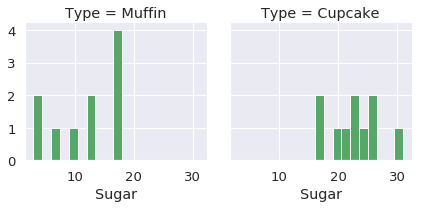

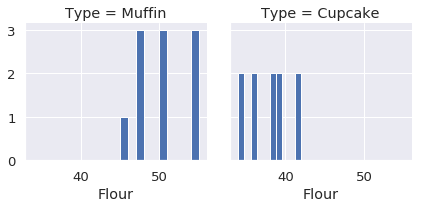

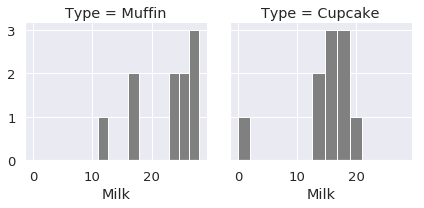

In [8]:
g = sns.FacetGrid(recipes, col="Type")
g.map(plt.hist, "Sugar", color='g');
g = sns.FacetGrid(recipes, col="Type")
g.map(plt.hist, "Flour", color='b');
g = sns.FacetGrid(recipes, col="Type")
g.map(plt.hist, "Milk", color='grey');
hide_toggle()

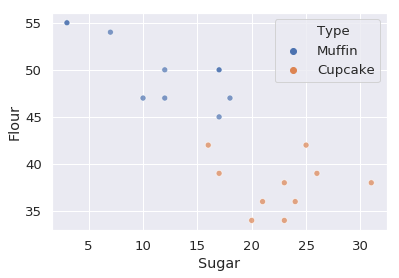

In [9]:
plt.figure()
sns.scatterplot("Sugar", "Flour", alpha=.7, hue='Type', data=recipes)


What if we can take all 8 ingredients and smush them down to only a few *'composite'* ingredients?

That way we can see with one glance the differences between muffins and cupcakes in all their ingredients.

In ML this is called 'Dimension reduction' 

Can you tell muffins and cupcakes apart from their ingredients?

<IPython.core.display.Javascript object>


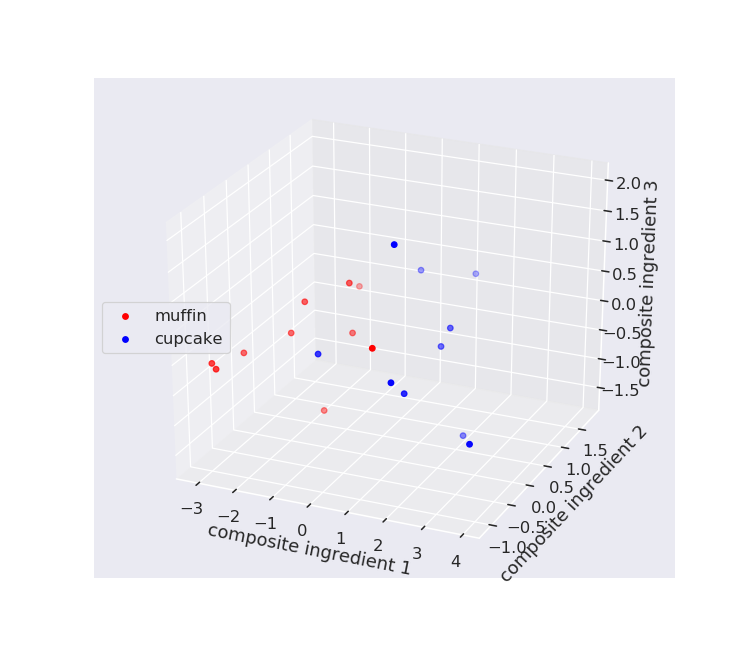

In [33]:
from sklearn_pandas import DataFrameMapper
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)
%matplotlib notebook

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
feature_list = list(recipes.columns)
feature_list.remove('Type')
num_features = len(feature_list)
type_label = np.where(recipes['Type']=='Muffin', 0, 1)
features_ma = recipes[feature_list]

# Separate Feature preprocessing of continuous and categorical variables
continuous_cols = feature_list[:-3]
categorical_cols = feature_list[-3:]
mapper = DataFrameMapper(
  [([continuous_col], StandardScaler()) for continuous_col in continuous_cols] +
  [(categorical_col, LabelEncoder()) for categorical_col in categorical_cols]
)
pipeline = Pipeline(
  [("mapper", mapper),
  ('dimension reduction', PCA(n_components=3,
                             svd_solver='randomized',
                             random_state=1,
                             whiten=False))]
)

transformed = pipeline.fit_transform(features_ma)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(transformed[:,0][labels=='Muffin'], transformed[:,1][labels=='Muffin'], transformed[:,2][labels=='Muffin'], c='red', label='muffin')
ax.scatter(transformed[:,0][labels=='Cupcake'], transformed[:,1][labels=='Cupcake'], transformed[:,2][labels=='Cupcake'], c='blue', label='cupcake')
#ax.scatter(transformed[:,0], transformed[:,1], transformed[:,2], c=type_label, cmap=cm_bright)
ax.set_xlabel('composite ingredient 1');
ax.set_ylabel('composite ingredient 2');
ax.set_zlabel('composite ingredient 3');
#ax.set_title('Can we tell muffins and cupcakes apart from their ingredients?', fontsize=12);
plt.legend(loc='center left');

pca = pipeline.named_steps['dimension reduction']
loadings = pca.components_

hide_toggle()


Do you think the computer can tell muffins and cupcakes apart from their ingredients?

Given some assumptions about what kind of *pattern* are in the data, we define a *'model'*. 

The computer will then tweak this model to best fit our data.

Here is how one model *decides* to tell muffins and cupcakes apart

<IPython.core.display.Javascript object>


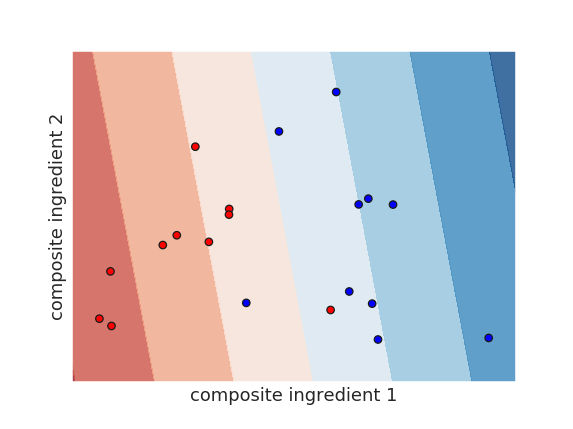

In [11]:
from matplotlib.colors import ListedColormap
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
h = .02  # step size in the mesh
type_label = np.where(recipes['Type']=='Muffin', 0, 1)

X = transformed[:, 0:2]
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h)
                     )

clf = svm.SVC(kernel='linear')
clf.fit(X, type_label)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

plt.figure()
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=type_label, cmap=cm_bright,
           edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(());
plt.xlabel('composite ingredient 1')
plt.ylabel('composite ingredient 2');
hide_toggle()

We can make a different set of assumptions and come up with a different model.

Let's see how it does:

<IPython.core.display.Javascript object>


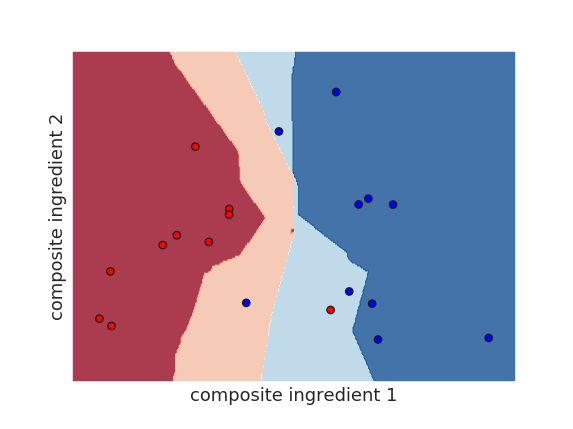

In [12]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, type_label) 

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
if hasattr(neigh, "decision_function"):
    Z = neigh.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = neigh.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

plt.figure()
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=type_label, cmap=cm_bright,
           edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(());
plt.xlabel('composite ingredient 1')
plt.ylabel('composite ingredient 2');
hide_toggle()

The computer is not too shabby at separating muffins from cupcakes!

Now that we have a 'model', 
can we tell whether a new recipe makes a muffin or a cupcake?

In machine learning, identifying the category of an observation is called **Classification**.

In [13]:
# Create a function to guess when a recipe is a muffin or a cupcake
def muffin_or_cupcake(ingredients):
    X = pipeline.transform(ingredients)
    if(clf.predict(X[:,0:2]))==0:
        print('You\'re looking at a muffin recipe!')
    else:
        print('You\'re looking at a cupcake recipe!')
    return X
        

new recipe: 
* Flour:53,
* Milk: 23,
* Sugar: 18,
* Butter: 7,
* Egg: 4,
* Baking Powder: 1,
* Vanilla: 0,
* Salt: 0
                 

In [36]:
unknown_recipe = pd.DataFrame([], columns=feature_list)
unknown_recipe.loc[0] = [53, 23, 18, 7, 4, 1, 0, 0]

<IPython.core.display.Javascript object>


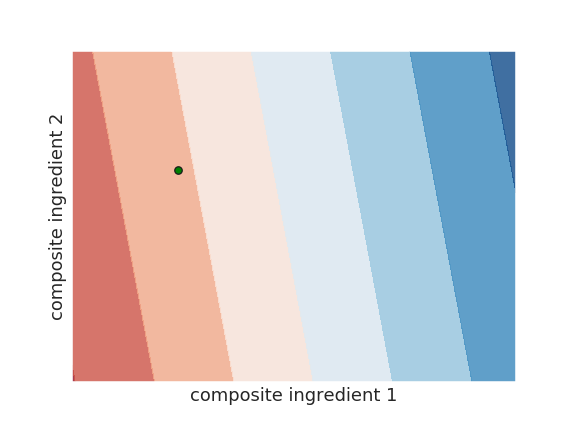

You're looking at a muffin recipe!


In [37]:
#muffin_or_cupcake(unknown_recipe)

from matplotlib.colors import ListedColormap
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
h = .02  # step size in the mesh
type_label = np.where(recipes['Type']=='Muffin', 0, 1)

X = transformed[:, 0:2]
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h)
                     )

clf = svm.SVC(kernel='linear')
clf.fit(X, type_label)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

plt.figure()
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

# Plot data points
transformed_new_recipe = muffin_or_cupcake(unknown_recipe)
plt.scatter(transformed_new_recipe[:,0], transformed_new_recipe[:,1], c='green',
           edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(());
plt.xlabel('composite ingredient 1')
plt.ylabel('composite ingredient 2');
hide_toggle()

Now let's say I just want to bake something that is edible.

I have a feeling the amount of flour needed in a recipe is dependent on the amount of the other ingredients.

Can we build a *model* that takes all the other ingredients and predit the amount of flour in a recipe?

Here I built a simple linear model that train on half of the recipes and predict on the other half.

<IPython.core.display.Javascript object>


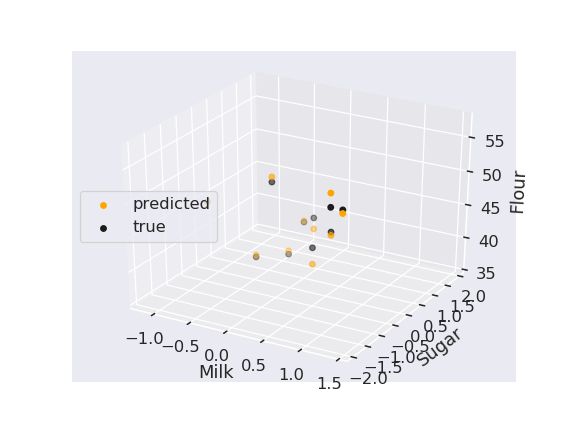

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
y = recipes['Flour'].values
X = recipes[feature_list[1:]]

continuous_cols = feature_list[1:-3]
categorical_cols = feature_list[-3:]
mapper = DataFrameMapper(
  [([continuous_col], StandardScaler()) for continuous_col in continuous_cols] +
  [(categorical_col, LabelEncoder()) for categorical_col in categorical_cols]
)
pipeline = Pipeline(
  [("mapper", mapper),
#   ('dimension reduction', PCA(n_components=2,
#                              svd_solver='randomized',
#                              random_state=1,
#                              whiten=False))
  ]
)

X_transformed = pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
     X_transformed, y, test_size=0.5, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test[:,0], X_test[:,1], y_pred, c='orange', label='predicted')
ax.scatter(X_test[:,0], X_test[:,1], y_test, c='k', label='true')
ax.set_xlabel(feature_list[1]);
ax.set_ylabel(feature_list[2]);
ax.set_zlabel('Flour');
#ax.set_title('Can we tell muffins and cupcakes apart from their ingredients?', fontsize=12);
plt.legend(loc='center left');

hide_toggle()

In ML, predicting a value based on previous experience is called a **Regression** problem

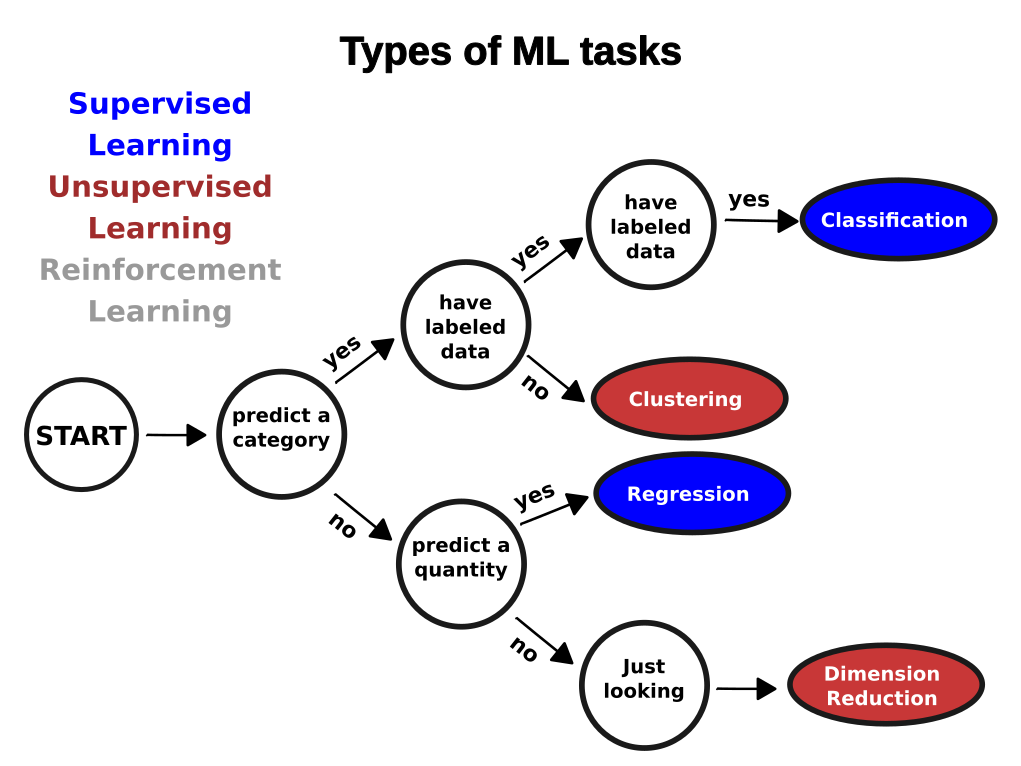

In [17]:
Image(filename='ML_tasks.png')